__модель “Плавающего окна”__

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
# !pip install pandas_datareader
# !pip install tsfresh

## загружаем данные

In [2]:
from tqdm.auto import tqdm
import numpy as np
from numpy import random as rng
import pandas as pd
from matplotlib import pyplot as plt
# import pandas_datareader.data as web
from pandas_datareader.data import DataReader

In [3]:
# Data from Google Finance
# data = DataReader("AAPL", "stooq")
# data = DataReader("GS", "stooq") 
data = DataReader("IBM", 'stooq')

In [4]:
data = data.rename(columns={'Close':'Value'})[['Value']].sort_index()
display( data.info() )
display( data.head() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2018-08-09 to 2023-08-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1256 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


None

,Value
Date,
2018-08-09,117.559
2018-08-10,117.315
2018-08-13,115.910
2018-08-14,116.428
2018-08-15,116.867


In [5]:
display(( data.index.min(), data.index.max() ))

(Timestamp('2018-08-09 00:00:00'), Timestamp('2023-08-07 00:00:00'))

In [6]:
time_split = '2022-01-01 00:00:00'
# time_split = f'{data.index.mean().year}-01-01 00:00:00'

data_train, data_test = data[:time_split].reset_index(), data[time_split:].reset_index()
display( ( data_train.shape, data_test.shape ) )

((856, 2), (400, 2))

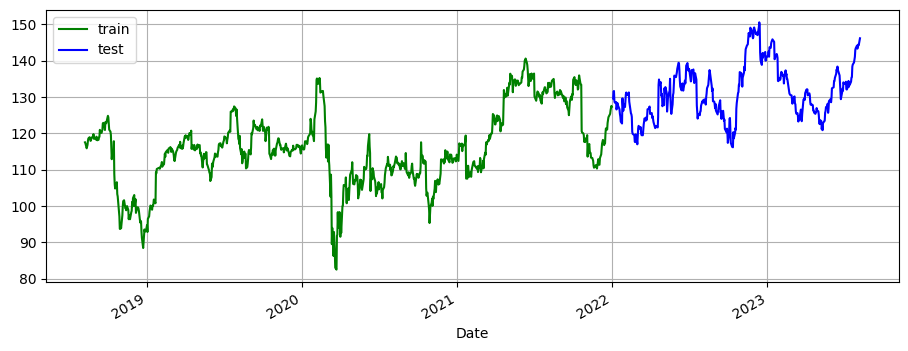

In [7]:
fig,ax = plt.subplots(figsize=(11,4))
data_train.set_index('Date')['Value'].plot(ax=ax,label='train',c='g')
data_test.set_index('Date')['Value'].plot(ax=ax,label='test',c='b')
plt.legend()
plt.grid()

In [8]:
assert data_train['Date'].max() < data_test['Date'].min()

## собираем учебный датасет

In [9]:
# data_train[['Value']].values

### масштабируем данные

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(data_train[['Value']].values)
data_train['Value_scale'] = scaler.transform(data_train[['Value']].values)
data_test['Value_scale'] = scaler.transform(data_test[['Value']].values)

### собираем последовательности

In [11]:
import tsfresh
from tsfresh.utilities import dataframe_functions as F

In [12]:
# для каждого значения формируем  историю предыдущих значений
data_train_roll = data_train.copy()
data_train_roll['symbols'] = 'S'

window_size = (3,7) # размер окна, по которому будем строить прогноз

data_train_roll = F.roll_time_series(
        data_train_roll,
        column_id='symbols', 
        column_sort='Date',
        # rolling_direction=1,
        min_timeshift=window_size[0],
        max_timeshift=window_size[1], 
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    ).drop(columns=['symbols'])

# метка группы
data_train_roll['id'] = pd.to_datetime(data_train_roll['id'].str[1])
display( data_train_roll.shape )
display( data_train_roll.head())

/opt/venv/nb_3.11/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


(6814, 4)

,Date,Value,Value_scale,id
688,2018-08-09,117.559,0.168194,2018-08-14
689,2018-08-10,117.315,0.144898,2018-08-14
690,2018-08-13,115.910,0.010757,2018-08-14
691,2018-08-14,116.428,0.060212,2018-08-14
692,2018-08-09,117.559,0.168194,2018-08-15


In [13]:
# # проверяем результат

# # выбираем временную метку
# d = pd.to_datetime('2019-07-10')

# # история значений для временной метки включая текущую (последняя)
# display( data_train_roll[ data_train_roll['id']==d ])

In [14]:
# # предыдущее от выбранной метки значение в окне
# display(data_train.shift(1).loc[[d]]) 

In [15]:
# # значение для временной метки
# display(data_train.loc[[d]]) 

In [16]:
# # следующее за выбранной меткой значение за окном 
# display(data_train.shift(-1).loc[[d]]) 

In [17]:
# assert ( data_train_roll[data_train_roll['id']==d]['Value'].values[-1] == data_train.loc[d].values[0] )

### собираем target

In [18]:
# желаемые значения прогноза для последовательностей
target_train = data_train.set_index('Date').shift(-1)['Value_scale'].dropna()
display(target_train.shape)
display(target_train)

(855,)

Date
2018-08-09    0.144898
2018-08-10    0.010757
2018-08-13    0.060212
2018-08-14    0.102126
2018-08-15    0.212017
                ...   
2021-12-23    0.916427
2021-12-27    1.008656
2021-12-28    1.073865
2021-12-29    1.125134
2021-12-30    1.102793
Name: Value_scale, Length: 855, dtype: float64

In [19]:
# display( (data_train_roll['id'].min(),data_train_roll['id'].max() ) )
# display( (target_train.index.min(),target_train.index.max()) ) 

### синхронизируем и выкидываем лишнее 

In [20]:
# выкидываем вектор-фичерсы без таргета
display( ( data_train_roll.shape, target_train.shape ) )
idx = set(data_train_roll['id']) & set(target_train.index)
data_train_roll = data_train_roll[ data_train_roll['id'].isin(idx) ].reset_index(drop=True).sort_values(by='id')
target_train = target_train[ target_train.index.isin(idx) ].sort_index()
display( ( data_train_roll.shape, target_train.shape ) )

((6814, 4), (855,))

((6806, 4), (852,))

In [21]:
# display( (min(idx),max(idx), ) )
# display( (data_train_roll['id'].min(),data_train_roll['id'].max() ) )
# display( (target_train.index.min(),target_train.index.max() ) )

### генерируем и отбираем признаки

In [22]:
%%time

# генерируем фичерсы для последовательностей

from tsfresh import extract_relevant_features

x_train = extract_relevant_features(
    data_train_roll, 
    target_train,
    column_id='id',
    column_sort='Date',
    column_value='Value_scale',
    show_warnings=False,
    disable_progressbar=True,
    n_jobs=4,
)

display( x_train.shape )
display( x_train.head() )

(852, 139)

,"Value_scale__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)",Value_scale__minimum,...,"Value_scale__fft_coefficient__attr_""real""__coeff_1",Value_scale__partial_autocorrelation__lag_2,Value_scale__ratio_value_number_to_time_series_length,Value_scale__percentage_of_reoccurring_datapoints_to_all_datapoints,Value_scale__has_duplicate,Value_scale__percentage_of_reoccurring_values_to_all_values,"Value_scale__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0",Value_scale__lempel_ziv_complexity__bins_100,Value_scale__has_duplicate_max,"Value_scale__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4"
2018-08-14,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,-0.075733,0.010757,...,0.157437,-0.312943,1.0,0.0,0.0,0.0,0.049456,1.0,0.0,0.000000
2018-08-15,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,-0.075733,0.010757,...,0.187113,-0.312943,1.0,0.0,0.0,0.0,0.045685,1.0,0.0,0.000000
2018-08-16,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,0.143109,0.010757,...,0.229998,-0.651770,1.0,0.0,0.0,0.0,-0.014258,1.0,0.0,0.023296
2018-08-17,-0.041502,-0.054539,0.236588,-0.054954,-0.039091,0.225264,0.172025,0.124101,0.238354,0.010757,...,0.230967,-0.676445,1.0,0.0,0.0,0.0,-0.014258,1.0,0.0,0.023296
2018-08-20,0.329269,0.325753,0.338028,0.251668,0.182154,0.337760,0.256364,0.184567,0.334252,0.010757,...,0.189883,-0.622685,1.0,0.0,0.0,0.0,-0.016517,1.0,0.0,0.023296


CPU times: user 2.58 s, sys: 254 ms, total: 2.83 s
Wall time: 11.4 s


In [23]:
del data_train_roll

In [24]:
feature_settings =  tsfresh.feature_extraction.settings.from_columns(x_train)
feature_order = x_train.columns

In [25]:
x_train

,"Value_scale__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_2__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_10__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","Value_scale__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)",Value_scale__minimum,...,"Value_scale__fft_coefficient__attr_""real""__coeff_1",Value_scale__partial_autocorrelation__lag_2,Value_scale__ratio_value_number_to_time_series_length,Value_scale__percentage_of_reoccurring_datapoints_to_all_datapoints,Value_scale__has_duplicate,Value_scale__percentage_of_reoccurring_values_to_all_values,"Value_scale__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.0",Value_scale__lempel_ziv_complexity__bins_100,Value_scale__has_duplicate_max,"Value_scale__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4"
2018-08-14,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,-0.075733,0.010757,...,0.157437,-0.312943,1.0,0.0,0.0,0.0,0.049456,1.0,0.0,0.000000
2018-08-15,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,-0.075733,0.010757,...,0.187113,-0.312943,1.0,0.0,0.0,0.0,0.045685,1.0,0.0,0.000000
2018-08-16,-0.041502,-0.054539,-0.049677,-0.054954,-0.039091,-0.062705,-0.051738,-0.035147,0.143109,0.010757,...,0.229998,-0.651770,1.0,0.0,0.0,0.0,-0.014258,1.0,0.0,0.023296
2018-08-17,-0.041502,-0.054539,0.236588,-0.054954,-0.039091,0.225264,0.172025,0.124101,0.238354,0.010757,...,0.230967,-0.676445,1.0,0.0,0.0,0.0,-0.014258,1.0,0.0,0.023296
2018-08-20,0.329269,0.325753,0.338028,0.251668,0.182154,0.337760,0.256364,0.184567,0.334252,0.010757,...,0.189883,-0.622685,1.0,0.0,0.0,0.0,-0.016517,1.0,0.0,0.023296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.788656,1.040691,0.868368,0.854890,0.628623,1.190595,0.964207,0.706067,1.218653,0.142225,...,-0.469673,-0.491998,1.0,0.0,0.0,0.0,0.075258,1.0,0.0,0.101012
2021-12-27,0.878635,1.169310,0.974264,0.956437,0.702394,1.349929,1.097837,0.804858,1.425866,0.142225,...,-0.486126,-0.061427,1.0,0.0,0.0,0.0,0.133211,1.0,0.0,0.071797
2021-12-28,0.937652,1.310861,1.082923,1.084201,0.798490,1.509670,1.223834,0.896366,1.608878,0.399338,...,-0.319780,-0.057566,1.0,0.0,0.0,0.0,0.086882,1.0,0.0,0.075950
2021-12-29,1.011214,1.432884,1.155147,1.187152,0.874665,1.673224,1.368885,1.005002,1.785360,0.502832,...,-0.355580,-0.561468,1.0,0.0,0.0,0.0,0.073587,1.0,0.0,0.084781


### масштабируем датасет 

In [26]:
scaler_fet = StandardScaler().fit(x_train.values)
x_train_scale = scaler_fet.transform(x_train.values)
# x_test_scale = scaler_fet.transform(x_test.values)

### собираем полиномиальные признаки

In [27]:
%%time 

from sklearn.preprocessing import PolynomialFeatures

poly_degree = 1 # степень полинома

# собираем полином, добавляем столбец из единиц (свободный член)
# poly = PolynomialFeatures(degree=poly_degree,).fit(x_train_scale)
poly = PolynomialFeatures(degree=poly_degree,interaction_only=True,).fit(x_train_scale)
x_train_scale_p = poly.transform(x_train_scale)

# x_train_scale_p = x_train_scale

display( x_train_scale_p.shape )

(852, 140)

CPU times: user 2.2 ms, sys: 409 µs, total: 2.61 ms
Wall time: 2.78 ms


## собираем тестовый датасет

In [28]:
%%time

# для каждого значения формируем  историю предыдущих значений
data_test_roll = data_test.copy().reset_index()
data_test_roll['symbols'] = 'S'

#window_size = (3,7) # размер окна, по которому будем строить прогноз

data_test_roll = F.roll_time_series(
        data_test_roll,
        column_id='symbols', 
        column_sort='Date',
        # rolling_direction=1,
        min_timeshift=window_size[0],
        max_timeshift=window_size[1], 
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    ).drop(columns=['symbols'])

# метка группы
data_test_roll['id'] = pd.to_datetime(data_test_roll['id'].str[1])
display( data_test_roll.shape )


# желаемые значения прогноза для последовательностей
target_test = data_test.set_index('Date').shift(-1)['Value_scale'].dropna()
# y_test = target_test.values[:,np.newaxis]
# display(y_test.shape)


# выкидываем вектор-фичерсы без таргета
idx = set(data_test_roll['id']) & set(target_test.index)
data_test_roll = data_test_roll[ data_test_roll['id'].isin(idx) ].reset_index(drop=True).sort_values(by='id')
target_test = target_test[ target_test.index.isin(idx) ].sort_index()
display( ( data_test_roll.shape, target_test.shape ) )


from tsfresh.feature_extraction import extract_features

x_test = extract_features(
        data_test_roll, 
        default_fc_parameters=feature_settings['Value_scale'],
        column_id='id', 
        column_sort='Date',
        column_value='Value_scale',
        disable_progressbar=True,
        impute_function=F.impute, 
        show_warnings=False,
        n_jobs=4,
    )[feature_order]


x_test_scale_p = poly.transform(  scaler_fet.transform(x_test.values)  )
# x_test_scale_p = scaler_fet.transform(x_test.values)
 
display( x_test_scale_p.shape )

/opt/venv/nb_3.11/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


(3166, 5)

((3158, 5), (396,))

(396, 140)

CPU times: user 481 ms, sys: 112 ms, total: 593 ms
Wall time: 2.5 s


## строим и обучаем предиктор

In [29]:
%%time 

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train_scale_p, target_train)

CPU times: user 25.3 ms, sys: 17 ms, total: 42.3 ms
Wall time: 31 ms


## тестируем

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
ws = window_size[1]+1 # размер окна истории предыдущих значений

### тест на учебном наборе

In [32]:
pred_train = model.predict(x_train_scale_p) # считаем выход для тестовых примеров
pred_train = pd.DataFrame({
        'Value_scale':pred_train,
        'Value':scaler.inverse_transform(pred_train[:,np.newaxis]).flatten()
        },
        index=x_train.index
    ).sort_index()

display( pred_train )

,Value_scale,Value
2018-08-14,0.102407,116.869947
2018-08-15,0.210710,118.004314
2018-08-16,0.270158,118.626975
2018-08-17,0.302331,118.963957
2018-08-20,0.294802,118.885096
...,...,...
2021-12-23,0.796760,124.142605
2021-12-27,0.962219,125.875621
2021-12-28,1.057495,126.873541
2021-12-29,1.073036,127.036318


In [33]:
# MSQE конечного результата после обратного масштабирования 
display( mean_squared_error( y_true=target_train[ws:], y_pred=pred_train['Value_scale'][ws:], ) )

0.03059439249363345

<Axes: xlabel='Date'>

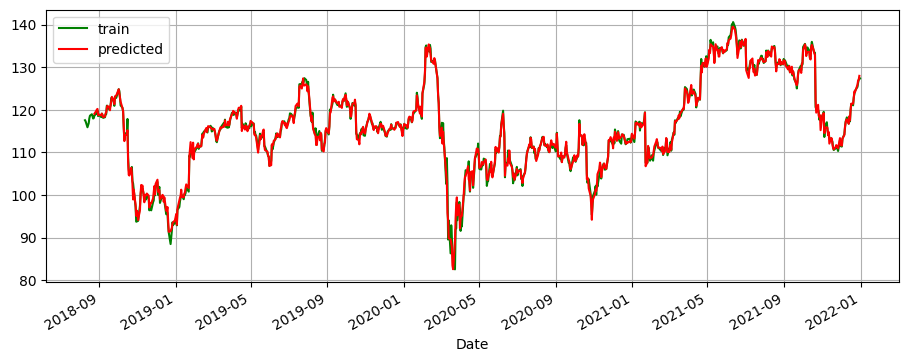

In [34]:
(
    data_train
    .set_index('Date')
    [['Value']]
    .rename(columns={'Value':'train'})
    .join( pred_train[['Value']].rename(columns={'Value':'predicted'})[ws:] )
    .plot(figsize=(11,4),grid=True,color={'train':'g','predicted':'r'})
)

### тест на тестовом наборе

0.03577456343554262

<Axes: xlabel='Date'>

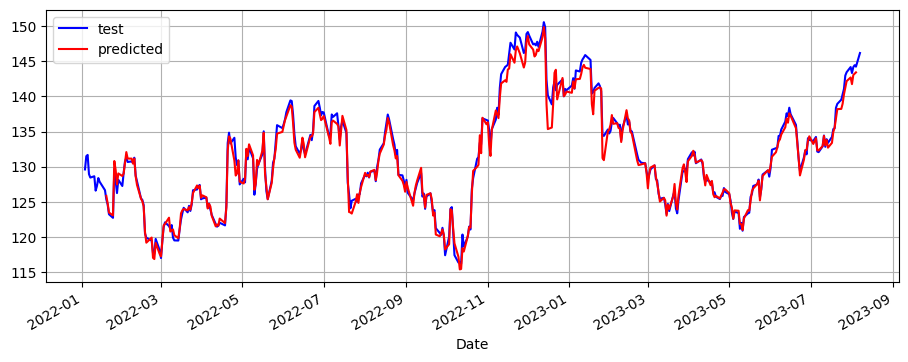

In [35]:
pred_test = model.predict(x_test_scale_p) # считаем выход для тестовых примеров
pred_test = pd.DataFrame({
    'Value_scale':pred_test,
    'Value':scaler.inverse_transform(pred_test[:,np.newaxis]).flatten()
    },
    index=x_test.index
).sort_index()

# MSQE конечного результата после обратного масштабирования 
display( mean_squared_error( y_true=target_test[ws:], y_pred=pred_test['Value_scale'][ws:], ) )

(
    data_test
    .set_index('Date')
    [['Value']]
    .rename(columns={'Value':'test'})
    .join( pred_test[['Value']].rename(columns={'Value':'predicted'})[ws:] )
    .plot(figsize=(11,4),grid=True, color={'test':'b','predicted':'r'})
)


## авторегрессор 

In [36]:
# авторегрессионный тест
# инициализируем модель начальной последовательностью из тестового набора
# далее прогноз строим на основании результатов самой модели на предыдущих итерациях

In [37]:
# ws = window_size[1]+1 # размер окна истории предыдущих значений

In [38]:
# вынимаем индекс (список дат) из data_test 
data_index = sorted( data_test['Date'] )
display(len(data_index))

400

In [39]:
# случайно выбираем начало тестовой последовательности
# n = 10
n = rng.randint( len(data_index)*0.5 )
display( n )

116

In [40]:
data_index_ = data_index[n:]
data_test_ = data_test[ data_test['Date'].isin( data_index_) ].set_index('Date').sort_index()

In [41]:
# вынимаем из data_test начальную последовательность
predicted = data_test_[:ws].copy()[['Value_scale']]

# выкидываем из индекса дат начальную последовательность
data_index_ = data_index_[ws:] 

display( len( data_index_) )
display( predicted )

276

,Value_scale
Date,
2022-06-21,1.788586
2022-06-22,1.716790
2022-06-23,1.843484
2022-06-24,2.180796
2022-06-27,2.249728
2022-06-28,2.162178
2022-06-29,2.055056
2022-06-30,2.099738


In [42]:
for d in tqdm(data_index_): # для всех дат из списка
    # формируем окно истории т.е. значения на предыдущих ws итерациях 
    data_w = predicted[-ws:].copy().reset_index() 
    data_w['id'] = d # общая метка для элементов последовательности
    try:
        # применяем features extractor
        x = extract_features(
            data_w, 
            default_fc_parameters=feature_settings['Value_scale'],
            column_id='id', 
            column_sort='Date',
            column_value='Value_scale',
            disable_progressbar=True,
            impute_function=F.impute, 
            show_warnings=False,
            n_jobs=4,
        )[feature_order]

        # масштабируем признаки, строим полином для регресии 
        # x = poly.transform( scaler_fet.transform(x.values) )
        x = poly.transform( scaler_fet.transform(x.values) )
        
        # считаем прогноз
        p = model.predict(x)

        # если предиктор перестал выдавать прогноз в разумных рамках, то завершаем процес
        assert (abs(p[0])<3.), f'predicted value ({p[0]:.4}) too large , stoped...'
        predicted.loc[d,'Value_scale'] = p[0]
        # обратное преобразование прогноза к исходному масштабу
        predicted.loc[d,'Value'] = scaler.inverse_transform(p[:,np.newaxis]).flatten()[0]
    except Exception as e:
        # если предиктор перестал выдавать прогноз, то завершаем процес
        print(e)
        break 

  0%|          | 0/276 [00:00<?, ?it/s]

In [43]:
display( predicted )

,Value_scale,Value
Date,,
2022-06-21,1.788586,NaN
2022-06-22,1.716790,NaN
2022-06-23,1.843484,NaN
2022-06-24,2.180796,NaN
2022-06-27,2.249728,NaN
...,...,...
2023-08-01,0.947519,125.721651
2023-08-02,0.962358,125.877083
2023-08-03,1.023504,126.517518


In [44]:
assert len(predicted)>ws*2

In [45]:
# res = pd.concat([
#         data_test.set_index('Date').rename(columns={'Value_scale':'test'}).loc[:d,'test'],
#         predicted[['Value_scale']][ws:].rename(columns={'Value_scale':'predicted'}),
#     ],axis=1)

# res.plot(grid=True,figsize=(11,4))

<Axes: xlabel='Date'>

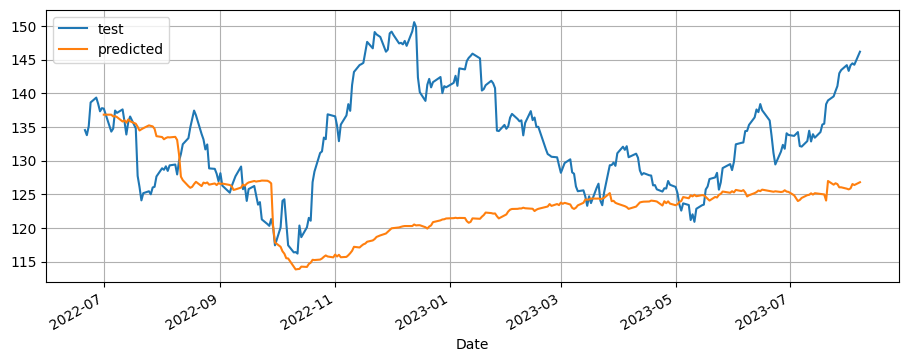

In [46]:
res = pd.concat([
        data_test_.rename(columns={'Value':'test'}).loc[:d,'test'],
        predicted[['Value']][ws:].rename(columns={'Value':'predicted'}),
    ],axis=1)

res.plot(grid=True,figsize=(11,4))

In [47]:
res = res.dropna()
display( res )

,test,predicted
Date,,
2022-07-01,137.722,136.827100
2022-07-05,134.307,136.821650
2022-07-06,134.755,136.559925
2022-07-07,137.439,136.605475
2022-07-08,137.088,136.465998
...,...,...
2023-08-01,143.330,125.721651
2023-08-02,144.170,125.877083
2023-08-03,144.450,126.517518


In [48]:
# MSQE конечного результата после обратного масштабирования 
display( mean_squared_error( y_true=res['test'], y_pred=res['predicted'], ) )

176.10396582104948


----